/tmp/ipykernel_745945/1515902314.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noiselevel = torch.tensor(noiselevel, dtype=torch.float32).to(device)


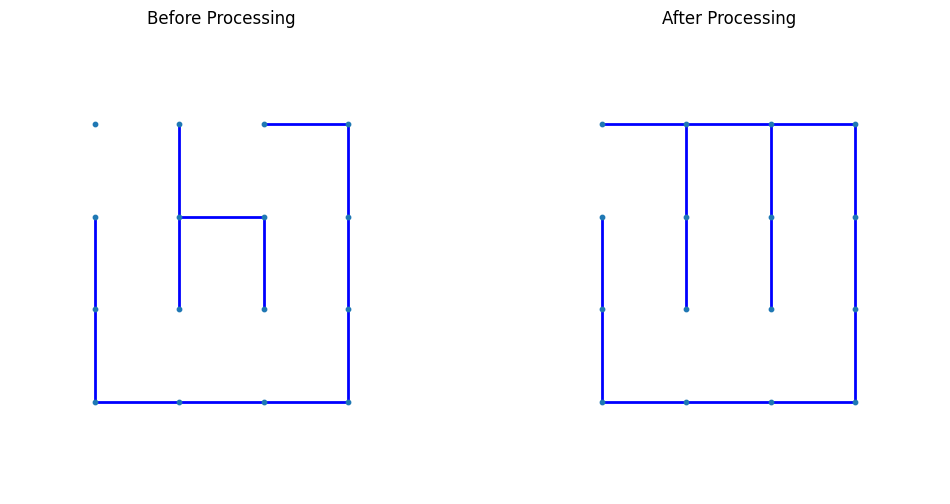

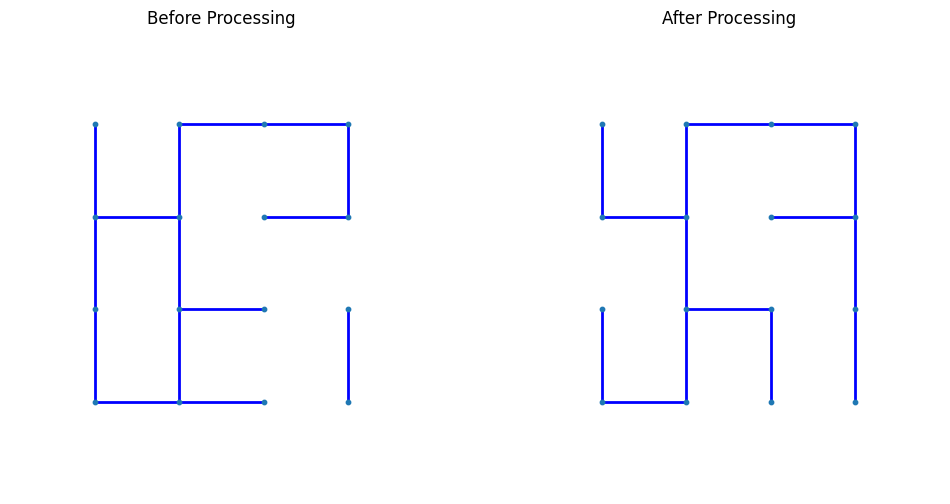

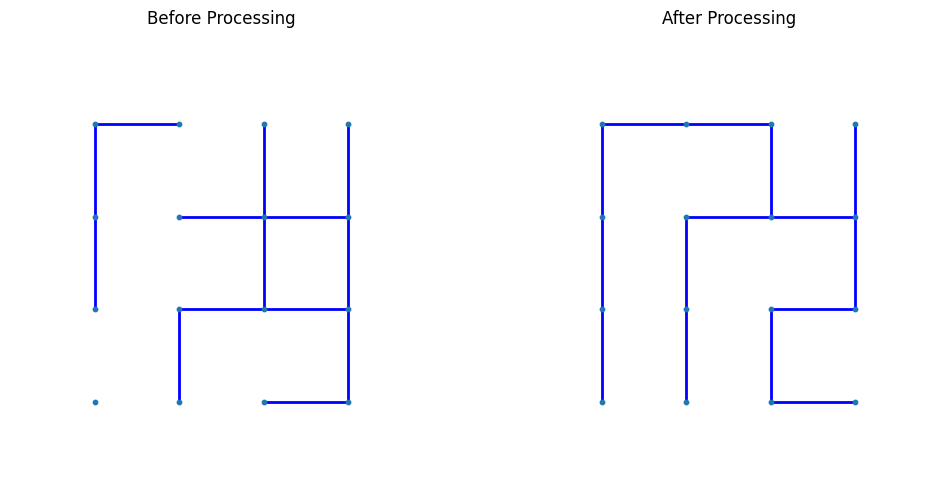

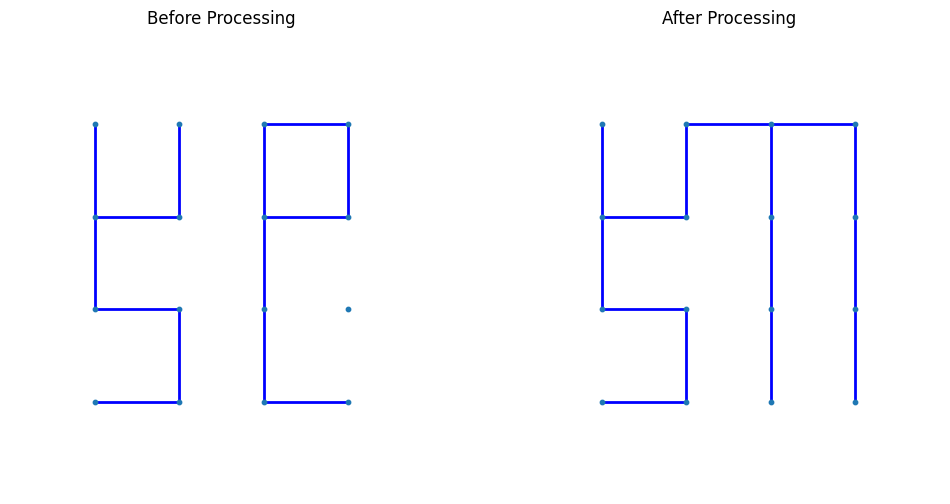

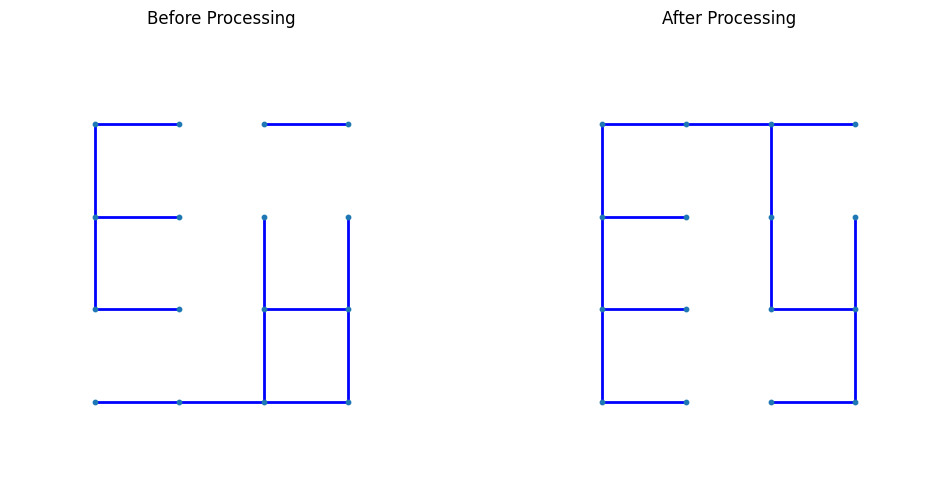

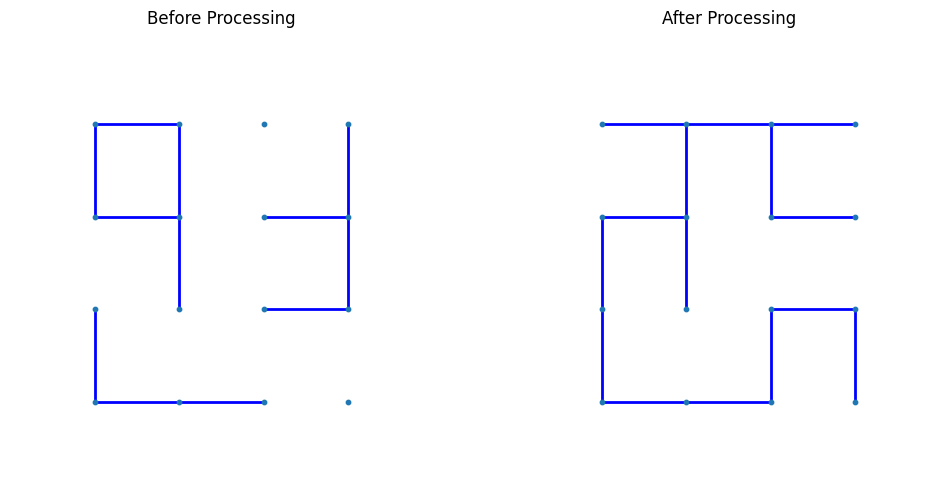

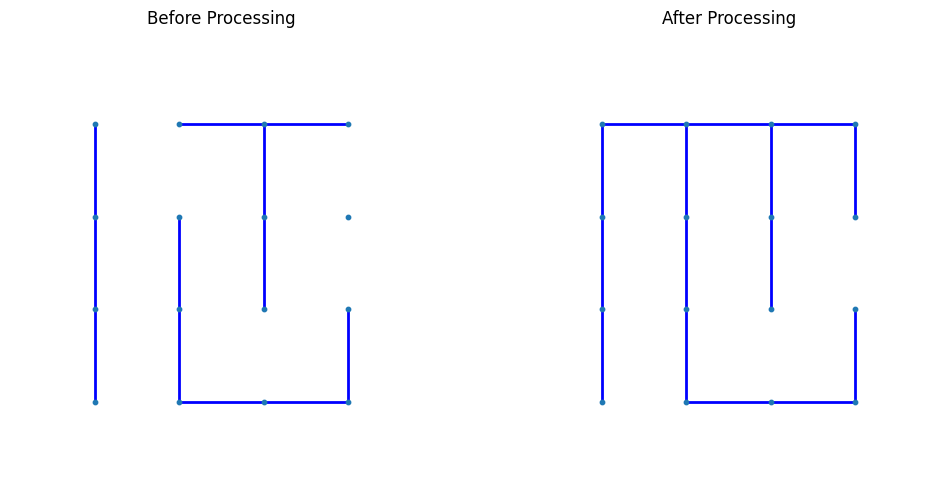

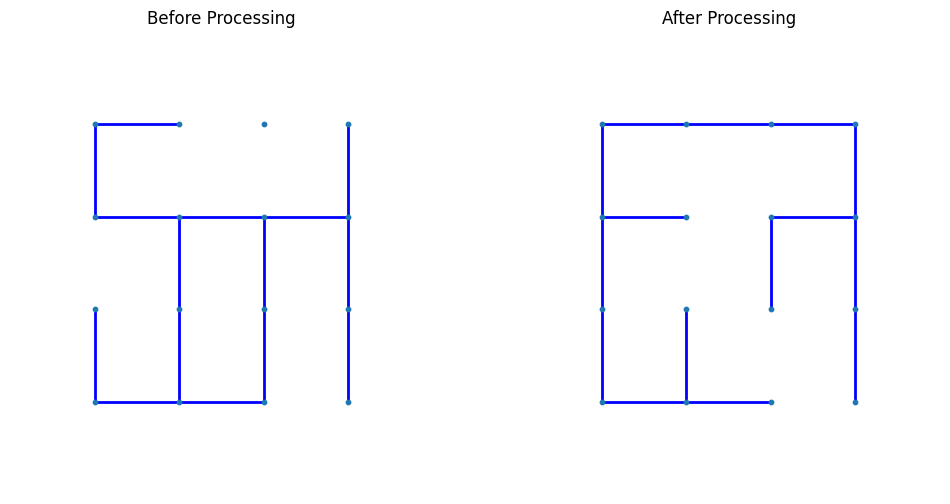

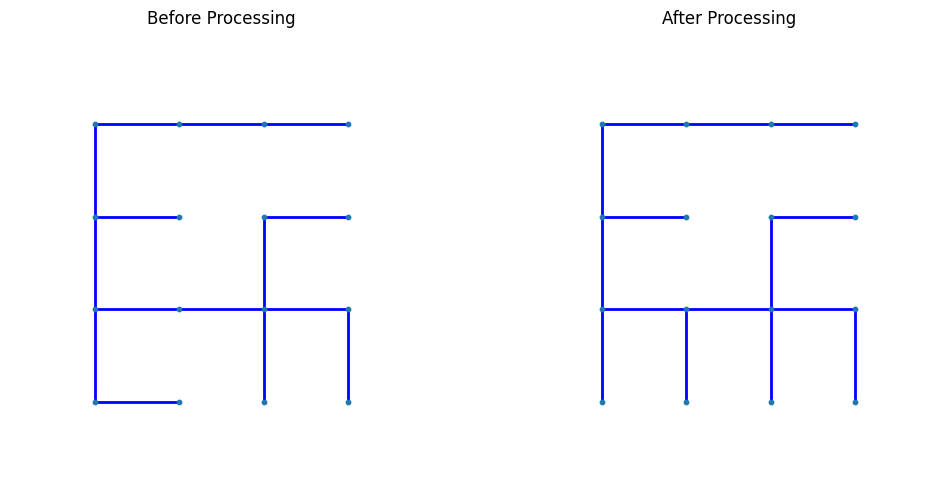

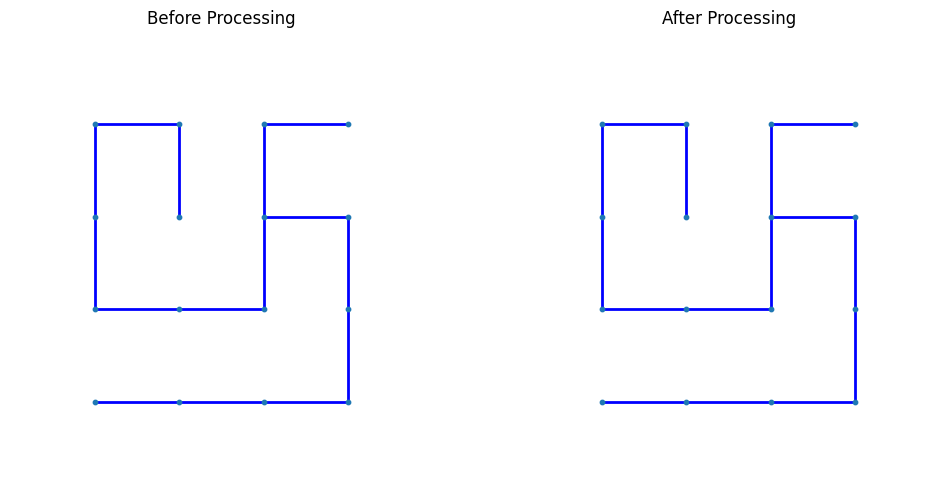

In [12]:
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from model.unet import Unet
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_neighbor, draw_maze_from_matrix, create_adjacency_mask,discretenoise_adj_neigh, draw_maze_before_after   

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
def plot_inter_graphs_jup(graphs,title,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}


width, height = 4, 4
batch_size = 1  

grid_shape = (4,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def visualize_graph2(G, title="Uniform Spanning Tree"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(title)
    plt.show()

def sample_ppgn_simple(noise_num):

    model = Unet(dim=64).to(device)
    model.load_state_dict(torch.load('models_unet/trained_model_unet_adj_neighbor_final.pth', map_location='cpu'))
    model.eval()
    
    test_batch_size = 1


    def gen_init_data(batch_size, grid_shape, device):
        size = grid_shape[0] * grid_shape[1]
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        
        bernoulli_adj = torch.zeros(batch_size, size, size).to(device)
        bernoulli_adj += adjacency_mask.unsqueeze(0) * 0.5  

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initial_matrix = noise_lower + noise_upper
        return initial_matrix



    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape=grid_shape)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        init_adjs = init_adjs.unsqueeze(1)
        noiselevel = noiselevel.unsqueeze(0)
        noise_unnormal = noise_func(adj_matrix=init_adjs.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(1)
        init_adjs = init_adjs.squeeze(1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs = new_adjs * adjacency_mask[None, :, :]
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)
                ##
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                ##
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noiselevel = torch.tensor(noiselevel, dtype=torch.float32).to(device)
                    noisy_adjs, init_adjs = take_step(lambda adj_matrix, noise: model(adj_matrix, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                draw_maze_before_after(init_adjs.detach().cpu().numpy()[0], width, height, grid_shape)
                gen_graph_list.append(init_adjs.cpu().numpy())

        # pic_title = f'final_sample_ipynb_{noise_num}.pdf'
        # #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        # plot_inter_graphs_jup(graphs=mult_stages, title='intermediate', nr_to_analyze=0)
        # plot_inter_graphs_jup(graphs=mult_stages_noise, title='intermediate', nr_to_analyze=0)
    result_dict = run_sample()

    return result_dict

sample_ppgn_simple(128)

In [6]:
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from model.unet import Unet
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_neighbor, draw_maze_from_matrix, create_adjacency_mask,discretenoise_adj_neigh

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
def plot_inter_graphs_jup(graphs,title,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}



width, height = 4, 4  
batch_size = 1  

grid_shape = (4,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def visualize_graph2(G, title="Uniform Spanning Tree"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(title)
    plt.show()

def sample_ppgn_simple(noise_num):
    
    model = Unet(dim=64).to(device)
    model.load_state_dict(torch.load('models_unet/trained_model_unet_adj_neighbor_2.pth', map_location='cpu'))
    model.eval()
    
    test_batch_size = 1

    def gen_init_data(batch_size, grid_shape, device):
        size = grid_shape[0] * grid_shape[1]
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        
        bernoulli_adj = torch.zeros(batch_size, size, size).to(device)
        bernoulli_adj += adjacency_mask.unsqueeze(0) * 0.5 

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initial_matrix = noise_lower + noise_upper
        return initial_matrix



    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape=(4, 4))

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        init_adjs = init_adjs.unsqueeze(1)
        noiselevel = noiselevel.unsqueeze(0)
        noise_unnormal = noise_func(adj_matrix=init_adjs.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(1)
        init_adjs = init_adjs.squeeze(1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs = new_adjs * adjacency_mask[None, :, :]
        return init_adjs, new_adjs

    def run_sample(eval_len=1, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)

                ##
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                ##

                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noiselevel = torch.tensor(noiselevel, dtype=torch.float32).to(device)
                    noisy_adjs, init_adjs = take_step(lambda adj_matrix, noise: model(adj_matrix, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    draw_maze_from_matrix(init_adjs.detach().cpu().numpy()[0], width, height, f'{count}')
                gen_graph_list.append(init_adjs.cpu().numpy())

        pic_title = f'final_sample_ipynb_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, title='intermediate', nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, title='intermediate', nr_to_analyze=0)
    result_dict = run_sample()

    return result_dict

sample_ppgn_simple(64)


RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "downs.2.0.res_conv.weight", "downs.2.0.res_conv.bias". 
	Unexpected key(s) in state_dict: "downs.3.0.mlp.1.weight", "downs.3.0.mlp.1.bias", "downs.3.0.ds_conv.weight", "downs.3.0.ds_conv.bias", "downs.3.0.net.0.weight", "downs.3.0.net.0.bias", "downs.3.0.net.1.weight", "downs.3.0.net.1.bias", "downs.3.0.net.3.weight", "downs.3.0.net.3.bias", "downs.3.0.net.4.weight", "downs.3.0.net.4.bias", "downs.3.0.res_conv.weight", "downs.3.0.res_conv.bias", "downs.3.1.mlp.1.weight", "downs.3.1.mlp.1.bias", "downs.3.1.ds_conv.weight", "downs.3.1.ds_conv.bias", "downs.3.1.net.0.weight", "downs.3.1.net.0.bias", "downs.3.1.net.1.weight", "downs.3.1.net.1.bias", "downs.3.1.net.3.weight", "downs.3.1.net.3.bias", "downs.3.1.net.4.weight", "downs.3.1.net.4.bias", "downs.3.2.fn.fn.to_qkv.weight", "downs.3.2.fn.fn.to_out.0.weight", "downs.3.2.fn.fn.to_out.0.bias", "downs.3.2.fn.fn.to_out.1.weight", "downs.3.2.fn.fn.to_out.1.bias", "downs.3.2.fn.norm.weight", "downs.3.2.fn.norm.bias", "downs.2.3.weight", "downs.2.3.bias", "ups.2.0.mlp.1.weight", "ups.2.0.mlp.1.bias", "ups.2.0.ds_conv.weight", "ups.2.0.ds_conv.bias", "ups.2.0.net.0.weight", "ups.2.0.net.0.bias", "ups.2.0.net.1.weight", "ups.2.0.net.1.bias", "ups.2.0.net.3.weight", "ups.2.0.net.3.bias", "ups.2.0.net.4.weight", "ups.2.0.net.4.bias", "ups.2.0.res_conv.weight", "ups.2.0.res_conv.bias", "ups.2.1.mlp.1.weight", "ups.2.1.mlp.1.bias", "ups.2.1.ds_conv.weight", "ups.2.1.ds_conv.bias", "ups.2.1.net.0.weight", "ups.2.1.net.0.bias", "ups.2.1.net.1.weight", "ups.2.1.net.1.bias", "ups.2.1.net.3.weight", "ups.2.1.net.3.bias", "ups.2.1.net.4.weight", "ups.2.1.net.4.bias", "ups.2.2.fn.fn.to_qkv.weight", "ups.2.2.fn.fn.to_out.0.weight", "ups.2.2.fn.fn.to_out.0.bias", "ups.2.2.fn.fn.to_out.1.weight", "ups.2.2.fn.fn.to_out.1.bias", "ups.2.2.fn.norm.weight", "ups.2.2.fn.norm.bias", "ups.2.3.weight", "ups.2.3.bias". 
	size mismatch for downs.2.0.net.1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 128, 3, 3]).
	size mismatch for downs.2.0.net.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.0.net.3.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.0.net.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.0.net.4.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for downs.2.0.net.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.1.mlp.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for downs.2.1.mlp.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.1.ds_conv.weight: copying a param with shape torch.Size([128, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([256, 1, 7, 7]).
	size mismatch for downs.2.1.ds_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.1.net.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.1.net.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.1.net.1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for downs.2.1.net.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.1.net.3.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.1.net.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for downs.2.1.net.4.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for downs.2.1.net.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.2.fn.fn.to_qkv.weight: copying a param with shape torch.Size([384, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 256, 1, 1]).
	size mismatch for downs.2.2.fn.fn.to_out.0.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for downs.2.2.fn.fn.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.2.fn.fn.to_out.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.2.fn.fn.to_out.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.2.fn.norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for downs.2.2.fn.norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for ups.1.0.net.1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for ups.1.0.net.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.0.net.3.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.0.net.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.0.net.4.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for ups.1.0.net.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.0.res_conv.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for ups.1.0.res_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.1.mlp.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([64, 256]).
	size mismatch for ups.1.1.mlp.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.1.ds_conv.weight: copying a param with shape torch.Size([128, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).
	size mismatch for ups.1.1.ds_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.1.net.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.1.net.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.1.net.1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for ups.1.1.net.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.1.net.3.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.1.net.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for ups.1.1.net.4.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for ups.1.1.net.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.2.fn.fn.to_qkv.weight: copying a param with shape torch.Size([384, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for ups.1.2.fn.fn.to_out.0.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 128, 1, 1]).
	size mismatch for ups.1.2.fn.fn.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.2.fn.fn.to_out.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.2.fn.fn.to_out.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.2.fn.norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.2.fn.norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for ups.1.3.weight: copying a param with shape torch.Size([128, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 4, 4]).
	size mismatch for ups.1.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).

Loaded 1 train graphs.


/tmp/ipykernel_745945/4282746593.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noiselevel = torch.tensor(noiselevel, dtype=torch.float32).to(device)


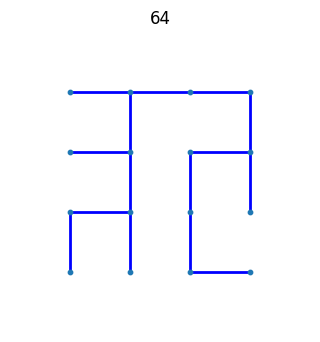

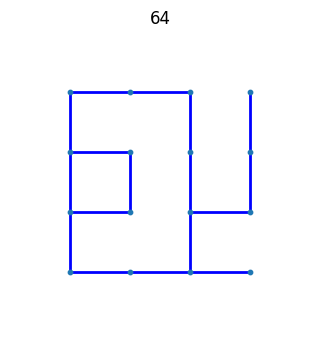

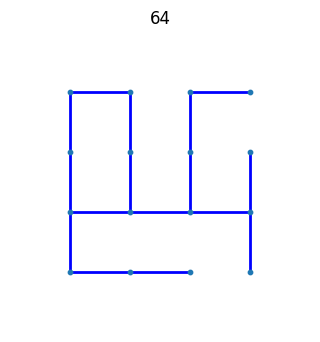

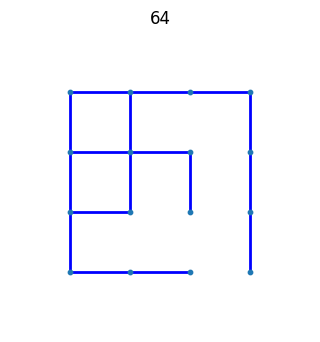

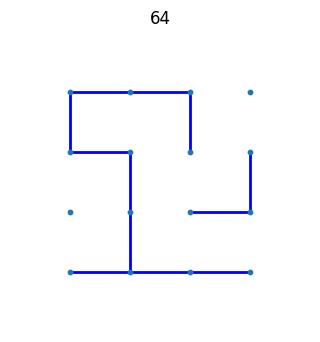

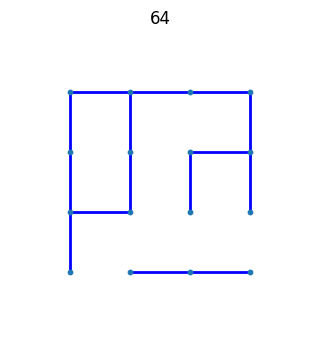

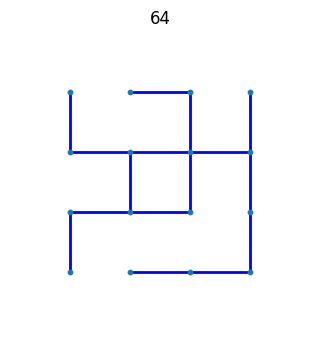

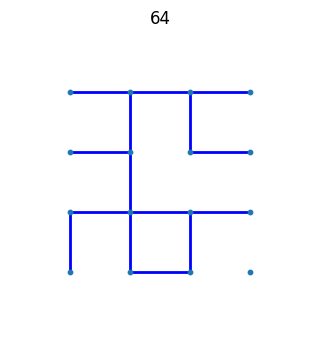

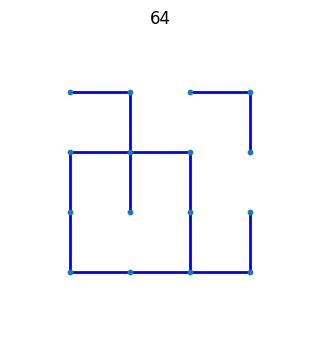

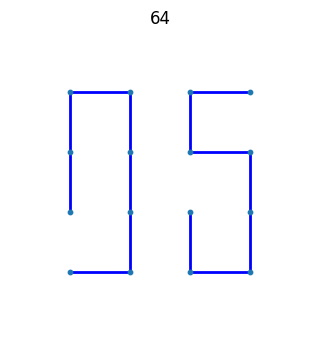